# Kernel methods for machine learning - image classification challenge

## Imports

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Helper functions

In [2]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid

### Implemented classes

In [3]:
from models import *
from utils import *

## Load data

In [4]:
Xtr = np.array(pd.read_csv('data/Xtr.csv', header=None, sep=',', usecols=range(3072)))
Xte = np.array(pd.read_csv('data/Xte.csv', header=None, sep=',', usecols=range(3072)))
Ytr = np.array(pd.read_csv('data/Ytr.csv', sep=',', usecols=[1])).squeeze()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
Ytr

array([8, 9, 3, ..., 1, 7, 5])

## Visualization

automobile


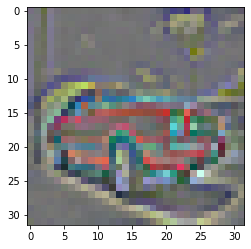

In [6]:
i = 1000
show_image(Xtr[i], classes[Ytr[i]])

## Training

Feature scaling:

In [ ]:
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)

Kernel ridge regression with linear kernel:

In [ ]:
clf = KernelRidgeClassifier(kernel='linear')
start = time.time()
clf.fit(Xtr_scaled, Ytr)
end = time.time()
print(f"fit completed in {end - start:2f} seconds")

**Kernel ridge regression with gaussian kernel:**

In [ ]:
clf = KernelRidgeClassifier(kernel='rbf')
start = time.time()
clf.fit(Xtr_scaled, Ytr)
end = time.time()
print(f"fit completed in {end - start:2f} seconds")

With cross-validation:

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
ridge = KernelRidgeClassifier(kernel='rbf')
params = {'C': [0.00001, 0.0001, 0.001, 0.01], 'gamma': [0.00001, 0.0001, 0.001, 0.01]}
clf = GridSearchCV(ridge, params, scoring='accuracy', cv=skf, verbose=5)
clf.fit(Xtr_scaled, Ytr)
print(clf.best_params_)
print(clf.best_score_)

In [ ]:
clf.cv_results_

## Predict and export

In [ ]:
Xte_scaled = scaler.transform(Xte)

In [ ]:
start = time.time()
Yte = clf.predict(Xte_scaled)
end = time.time()
print(f"predict completed in {end - start:.2f} seconds")

In [ ]:
Yte = {'Prediction' : Yte}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('Yte_pred_krr_rbf_C0.00001_gamma0.0001_scaled.csv', index_label='Id')

## Tests

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import RidgeClassifier

In [ ]:
X, y = make_classification(n_informative=5, n_classes=10)
y

In [ ]:
clf = KernelRidgeClassifier(kernel='rbf', gamma=0.01, verbose=False)
clf.fit(X, y)
clf.predict(X)

In [ ]:
clf.K.similarity_matrix()

In [ ]:
clf = RidgeClassifier(fit_intercept=False)
clf.fit(X, Ytr)
Yte = clf.predict(Xte_scaled)

### Comparison for regression

In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression

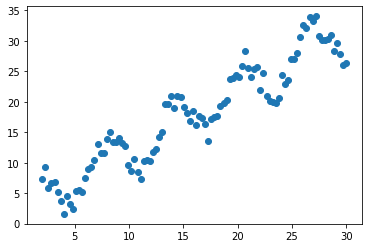

In [8]:
x = np.linspace(2,30,100)
y= x + 4*np.sin(x)+ 4*np.random.rand(x.shape[0])
plt.scatter(x, y)
plt.show()

In [9]:
C = 0.01
gamma = 10

In [10]:
x = StandardScaler().fit_transform(x.reshape(-1,1))[:,0]
reg = KernelRidgeRegressor(C=C/len(x), kernel='rbf', gamma=gamma)
reg.fit(x.reshape(-1,1), y)
x_pred=np.arange(0,35,0.2)
x_pred = StandardScaler().fit_transform(x_pred.reshape(-1, 1))[:,0]
y_pred = reg.predict(x_pred)

Start computing kernel similarity matrix...
Kernel similarity matrix computed in 0.00 seconds
Predicting...


100%|██████████| 175/175 [00:00<00:00, 1428.10it/s]


In [11]:
reg2 = KernelRidge(alpha=C, kernel='rbf', gamma=gamma)
reg2.fit(x.reshape(-1,1), y)
y_pred2 = reg2.predict(x_pred.reshape(-1,1))

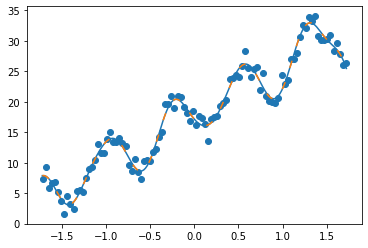

In [12]:
plt.scatter(x, y)
plt.plot(x_pred, y_pred)
plt.plot(x_pred, y_pred2, linestyle=(0, (5, 10)))
plt.show()

In our implementation, regularization is multiplied by the number of training examples. Fixing the regularization factor, its behavior is the same as sklearn's KernelRidge if the value is divided by the number of examples. It is also important to standardize.

In [13]:
X, y = make_regression(n_samples=1000, n_features=500)
#X = StandardScaler().fit_transform(X)

reg1 = KernelRidgeRegressor(C=C/len(X), kernel='rbf', gamma=gamma)
reg1.fit(X, y)
y_pred1 = reg1.predict(X)

reg2 = KernelRidge(alpha=C, kernel='rbf', gamma=gamma)
reg2.fit(X, y)
y_pred2 = reg2.predict(X)

Start computing kernel similarity matrix...
Kernel similarity matrix computed in 0.14 seconds
Predicting...


100%|██████████| 1000/1000 [00:07<00:00, 132.03it/s]


In [14]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y, y_pred1))
print(mean_squared_error(y, y_pred2))

3.096179128528922
3.096179128528922
